Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# YahooMusic

In [3]:
# importa dataset 'yahoomusic'
data = pd.read_csv("../datasets/ymusic_gte90_6kusers.tsv","\t")

## **PROBLEM**: HAS NO DATE - ONLY FIXED SIZED BUCKETS ANALYSIS

In [ ]:
# Necessary Preprocess - create date from timestamp
data['date'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).date() )
data['year'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).year)
data['month'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).month )
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

In [177]:
# this lets me sample the first 10% of the dataset to avoid cold start.
# data.iloc[ :int( 0.1*data.shape[0] ) ]

## Evaluating Time defined Buckets 

How many interactions occur in each month?

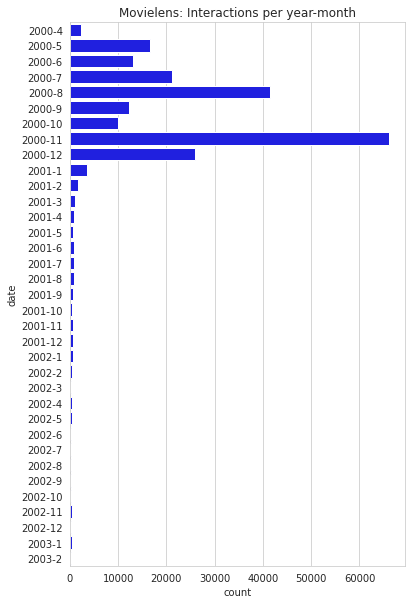

In [8]:
plot_interactions_per_month(data=data, dataset_name='Movielens')

What is the user presence distribution based on month, quarter, and semester?

In [171]:
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col='UserID')

In [176]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
5941,195,0.742857,0.833333,0.833333
3975,1088,0.685714,0.833333,0.833333
4950,1733,0.628571,0.833333,0.833333
5398,343,0.600000,0.833333,0.833333
5768,424,0.571429,0.833333,0.833333


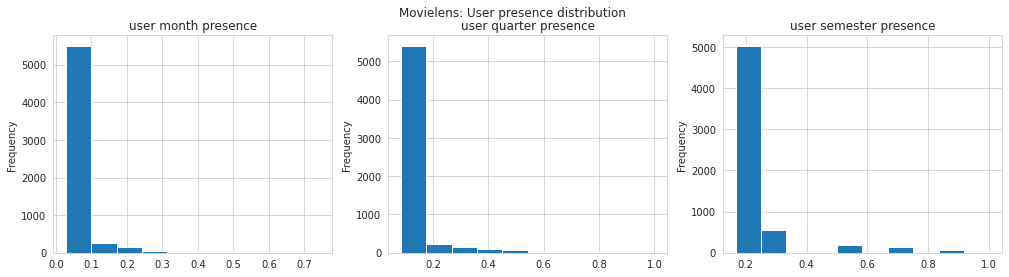

In [11]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name='Movielens')

How many examples are there per quarter and semester?

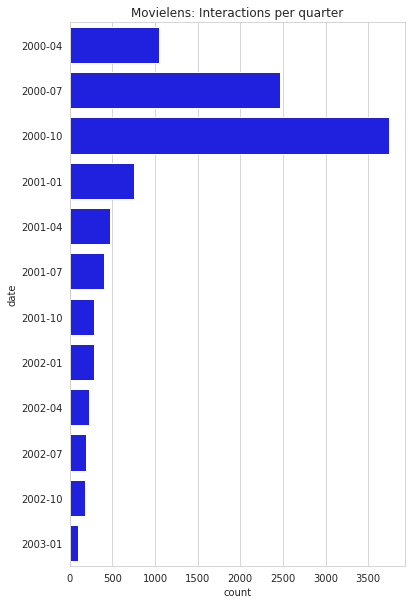

In [12]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name='Movielens', type_of_range='quarter')

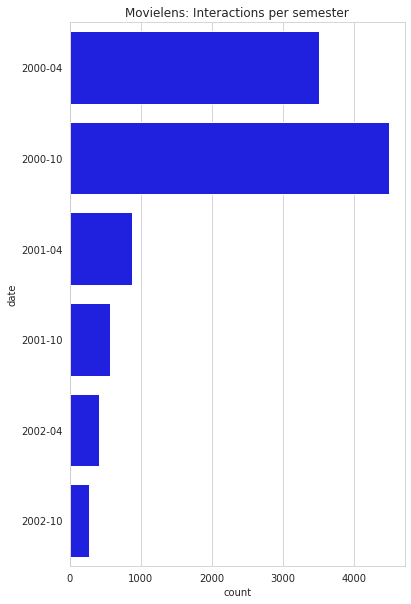

In [13]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name='Movielens', type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [ ]:
# defining threshold
frequency_threshold = 0.8

In [180]:
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

0 users of 6014 (0.0%) occurr in 80.0% or more months (of 35).
9 users of 6014 (0.15%) occurr in 80.0% or more quarters (of 12).
93 users of 6014 (1.546%) occurr in 80.0% or more semesters (of 6).


In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [204]:
freq_user_quarter_info = get_frequent_user_statistics(
    interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
freq_user_quarter_info

# usuário frequente visto ao menos uma vez anteriormente - holdout

,possible_holdout_users,median_freq_user_interactions
0,2,0.0
1,1,0.0
2,5,2.0
3,7,2.0
4,6,2.0
5,5,2.0
6,5,2.0
7,7,2.0
8,7,3.0
9,6,3.0


In [202]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [203]:
freq_user_semester_info = get_frequent_user_statistics(
    interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
freq_user_semester_info

,possible_holdout_users,median_freq_user_interactions
0,33,1.0
1,72,2.0
2,57,2.0
3,47,2.0
4,53,2.0
5,32,1.0


In [205]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [206]:
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions.loc[frequent_users_trimestre]
user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [4]:
n_iter_bucket = 50E3

interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

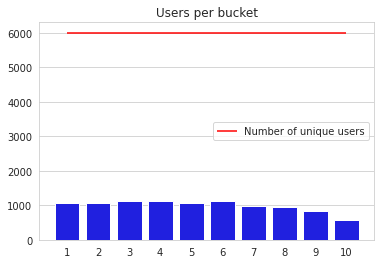

In [5]:
plot_users_per_fixed_bucket(data, 'user_id', interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [6]:
user_bucket_interactions_df = get_fixed_buckets_info(data, 'user_id', interval_start, interval_end)

No 'date' columns


In [7]:
frequency_threshold = 0.8

In [8]:
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

33 users of 6000 (0.55%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

<AxesSubplot:>

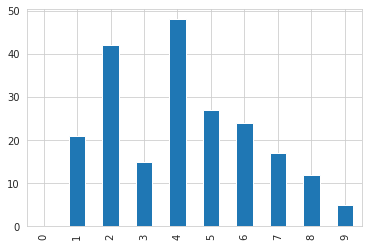

In [9]:
freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)
freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

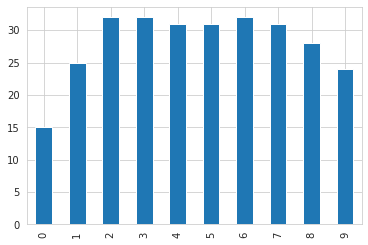

In [10]:
freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

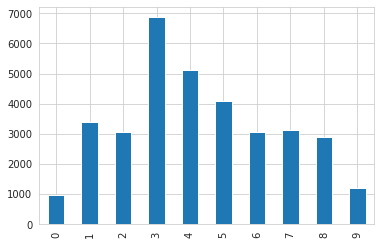

In [11]:
# frequent users interactions per bucket
plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

In [12]:
# no timestamp
# plot_timestamps_per_bucket(dates_fixed_buckets_df)

___
## Store Buckets

In [ ]:
stream = ImplicitData(data['user_id'],data['item_id'])
empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 200
num_iter = 9
learn_rate = 0.25
regularization = 0.45
num_nodes = 16

In [ ]:
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_ymusic = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_ymusic.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 42 min

In [ ]:
joblib.dump(eval_ymusic, 'output/joblib_bucket_info_dump/eval_ymusic', compress=True)